In [2]:
import pandas as pd
import urllib.parse
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
df = pd.read_csv('properties_data.csv')
df = df.drop_duplicates(subset='id')
df = df.drop(df[df["Type"].isin(["house group", "apartment group"])].index)

duplicate_columns = df.columns[df.columns.duplicated()]
df = df.loc[:, ~df.columns.duplicated()]

filtered_columns = ["id","location","Zip","Type","Subtype",
    "Price","Transaction Type","Bedrooms","Living area","Kitchen type",
    "Furnished","How many fireplaces?","Terrace","Terrace surface",
    "Garden","Garden surface","Surface of the plot","Number of frontages",
    "Swimming pool","Building condition","Primary energy consumption"]
df = df[filtered_columns]

df = df.rename(columns={
    'location' :'Locality',
    'Transaction Type' : 'Type of sale',
    'Type' :'Type of property',
    'Subtype' : 'Subtype of property',
    'Number of frontages': 'Number of facades',
    'Bedrooms':'Number of rooms',
    'Surface of the plot' :'Surface of the land',
    'Kitchen type' : 'Fully equipped kitchen',
    'How many fireplaces?' : 'Open fire'
})

#put the columns in a specific order
df = df.reindex(columns=['id', 'Locality',"Zip", 'Type of property', 'Subtype of property',
                         'Type of sale', 'Price', 'Number of facades', 'Number of rooms', 
                         'Living area', 'Fully equipped kitchen', 'Furnished','Primary energy consumption',
                         'Surface of the land', 'Terrace', 'Terrace surface',
                         'Garden','Garden surface', 'Open fire', 
                         'Swimming pool'])

def clean_and_convert(column):
    column = column.apply(lambda x: re.sub('\D+', '', str(x)))
    column = column.replace('', np.nan).fillna(0).astype(int)
    return column

def nan_replacement(column):
    column = column.replace("Yes",1)
    column = column.replace("No",0)
    column = column.replace('', np.nan).fillna(0)
    return column

def facade_replacement(column):
    return np.where(column > 4.0 ,np.nan,column)

df['Number of facades'] = facade_replacement(df['Number of facades'])
df['Furnished'] = nan_replacement(df['Furnished'])
df['Swimming pool'] = nan_replacement(df['Swimming pool'])
df['Open fire'] = nan_replacement(df['Open fire'])
df['Locality'] = df['Locality'].apply(urllib.parse.unquote)
df['Locality'] = df['Locality'].str.lower()
df['Living area'] = clean_and_convert(df['Living area'])
df['Terrace surface'] = clean_and_convert(df['Terrace surface'])
df['Garden surface'] = clean_and_convert(df['Garden surface'])
df['Primary energy consumption'] = clean_and_convert(df['Primary energy consumption'])
df['Garden'] = clean_and_convert(df['Garden surface'])
df['Surface of the land'] = clean_and_convert(df['Surface of the land'])

df.to_csv('properties_clean.csv', index=False)

/tmp/ipykernel_207/3006718698.py:1: DtypeWarning: Columns (41,42,43,44,90,91,92,93,113,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('properties_data.csv')


df.describe()

In [38]:
df.describe()

,id,Zip,Number of facades,Number of rooms,Living area,Furnished,Primary energy consumption,Surface of the land,Terrace surface,Garden,Garden surface,Open fire,Swimming pool
count,1.866300e+04,18663.000000,14223.000000,18316.000000,18663.000000,18663.000000,1.866300e+04,18663.000000,18663.000000,18663.000000,18663.000000,18663.000000,18663.000000
mean,1.042080e+07,4789.945775,2.758771,3.029646,179.471093,0.040079,5.259605e+09,697.502384,13.241012,275.565343,275.565343,0.057601,0.029792
std,2.310011e+05,3166.567583,0.859376,1.657928,1297.974308,0.196150,7.185282e+11,5669.115053,41.126757,7159.381176,7159.381176,0.259126,0.170016
min,7.710166e+06,1000.000000,1.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.038658e+07,1600.000000,2.000000,2.000000,90.000000,0.000000,1.100000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.049557e+07,4100.000000,2.000000,3.000000,134.000000,0.000000,2.230000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.054716e+07,8301.000000,4.000000,4.000000,202.000000,0.000000,3.680000e+02,460.000000,16.000000,1.000000,1.000000,0.000000,0.000000
max,1.057969e+07,9992.000000,4.000000,39.000000,175173.000000,1.000000,9.816000e+13,500000.000000,3286.000000,900000.000000,900000.000000,10.000000,1.000000


In [39]:
print(f"The DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")


The DataFrame has 18663 rows and 20 columns.


In [40]:
def get_encoded_df(df, columns):
    # Encodes the categorical columns to be used in correlation computation
    df = pd.get_dummies(df, columns=columns)
    return df

def get_correlation(df, target_column):
    # Converts the target column to numeric values + override errors
    df[target_column] = pd.to_numeric(df[target_column], errors='coerce')
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns.remove('id')
    numeric_columns.remove('Zip')
    
    # Correlation target column with numeric columns
    return df[numeric_columns].corr()[target_column].sort_values(ascending=False)

df_houses = df[df['Type of property'] == 'house']
df_apartments = df[df['Type of property'] == 'apartment']

df_encoded = get_encoded_df(df, ['Type of property', 'Fully equipped kitchen', 'Furnished'])

print("All properties:")
correlation_encoded = get_correlation(df_encoded, 'Price')
print(correlation_encoded)
print()

print("Houses:")
correlation_houses = get_correlation(df_houses, 'Price')
print(correlation_houses)
print()

print("Apartments:")
correlation_apartments = get_correlation(df_apartments, 'Price')
print(correlation_apartments)



All properties:
Price                         1.000000
Number of rooms               0.389212
Swimming pool                 0.291939
Surface of the land           0.204275
Number of facades             0.165379
Terrace surface               0.144782
Open fire                     0.121780
Living area                   0.063568
Garden                        0.047015
Garden surface                0.047015
Primary energy consumption   -0.002877
Name: Price, dtype: float64

Houses:
Price                         1.000000
Number of rooms               0.421069
Swimming pool                 0.338071
Surface of the land           0.236961
Number of facades             0.187551
Open fire                     0.118898
Terrace surface               0.092716
Living area                   0.059519
Furnished                     0.056595
Garden                        0.054472
Garden surface                0.054472
Primary energy consumption   -0.008382
Name: Price, dtype: float64

Apartments:
Price    

/tmp/ipykernel_207/4239039735.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_column] = pd.to_numeric(df[target_column], errors='coerce')
/tmp/ipykernel_207/4239039735.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_column] = pd.to_numeric(df[target_column], errors='coerce')


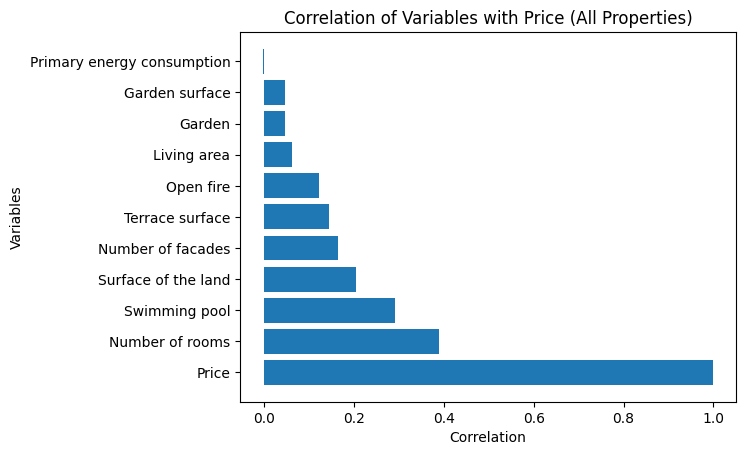

In [41]:
plt.barh(correlation_encoded.index, correlation_encoded.values)
plt.xlabel('Correlation')
plt.ylabel('Variables')
plt.title('Correlation of Variables with Price (All Properties)')
plt.show()

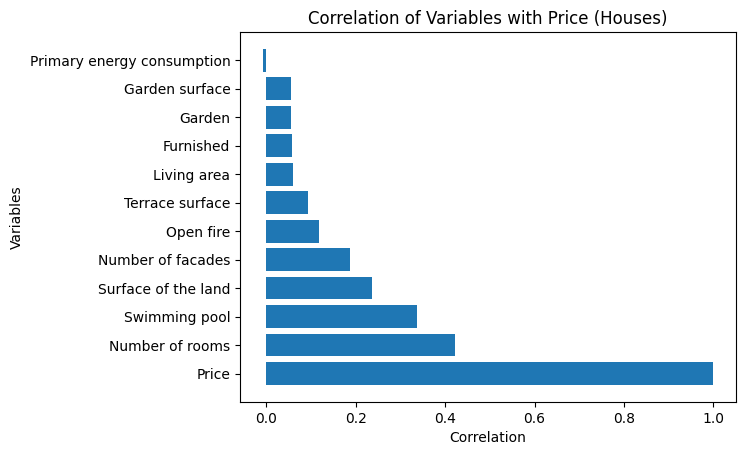

In [42]:
plt.barh(correlation_houses.index, correlation_houses.values)
plt.xlabel('Correlation')
plt.ylabel('Variables')
plt.title('Correlation of Variables with Price (Houses)')
plt.show()

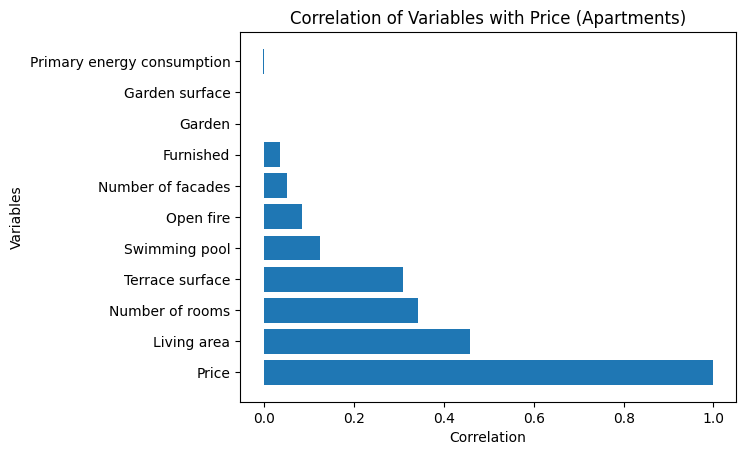

In [43]:
plt.barh(correlation_apartments.index, correlation_apartments.values)
plt.xlabel('Correlation')
plt.ylabel('Variables')
plt.title('Correlation of Variables with Price (Apartments)')
plt.show()

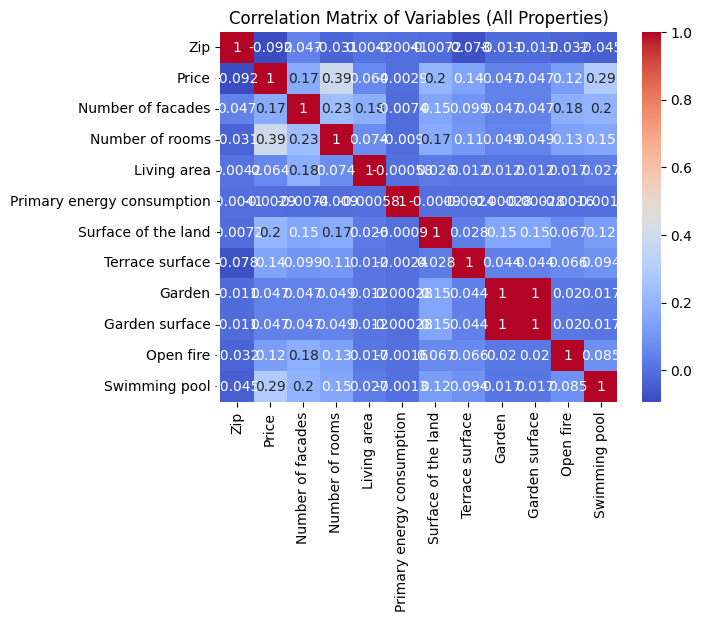

In [44]:
df_encoded_numeric = df_encoded.select_dtypes(include=[np.number]).drop('id', axis=1)
corr_matrix = df_encoded_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Variables (All Properties)')
plt.show()

